# Mercedes tuned XGB model

This is based on the the initial template for XGB analysis of the data with additional PCA for features.

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_palette('muted')
import time

import xgboost as xgb
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline, make_union, FeatureUnion
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.base import BaseEstimator,TransformerMixin, ClassifierMixin
from sklearn.utils import check_array
from sklearn.linear_model import ElasticNetCV, LassoLarsCV, LarsCV
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
import os
os.environ['PATH']

'/Users/dario/anaconda/bin:/usr/local/bin:/usr/bin:/bin:/usr/sbin:/sbin:/opt/X11/bin'

In [3]:
xgb.__version__

'0.6'

In [4]:
os.getcwd()

'/Users/dario/Documents/mercedes-manufacturing'

In [32]:
class StackingEstimator(BaseEstimator, TransformerMixin):
    
    def __init__(self, estimator):
        self.estimator = estimator
        
    def fit(self, X, y=None, **fit_params):
        self.estimator.fit(X, y, **fit_params)
        return self
    
    def transform(self, X):
        X = check_array(X)
        X_transformed = np.copy(X)
        
        # add class probabilities as a synthetic feature
        if issubclass(self.estimator.__class__, ClassifierMixin) and hasattr(self.estimator, 'predict_proba'):
            X_transformed = np.hstack((self.estimator.predict_proba(X), X))

        # add class prediction as a synthetic feature
        X_transformed = np.hstack((np.reshape(self.estimator.predict(X), (-1, 1)), X_transformed))

        return X_transformed

# Data preprocessing

In [60]:
# load train and test data
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')

(train.shape, test.shape)

((4209, 378), (4209, 377))

In [61]:
# merge train and test data for feature prepping
merged_data = pd.concat([train, test], keys=['train', 'test'])

# convert categorical variables to dummies
merged_data = pd.get_dummies(merged_data)

# split data back into train and test
train = merged_data.loc['train']
test = merged_data.loc['test']
# note that both dataframes now have the same number of columns (both have 'y')
len(merged_data.loc['train'].columns) == len(merged_data.loc['test'].columns)

True

In [62]:
# get X and y for training
X_train = train.drop(['ID','y'], axis=1)
y_train = train['y']

# get X for testing
X_test = test.drop(['ID','y'], axis=1)

In [64]:
X_train.shape, y_train.shape, X_test.shape

((4209, 579), (4209,), (4209, 579))

# Model stacking

In [73]:
stacked_pipeline = make_pipeline(
    StackingEstimator(estimator=LassoLarsCV(normalize=True)),
    StackingEstimator(estimator=GradientBoostingRegressor(learning_rate=0.001, loss="huber", max_depth=3, 
                                                          max_features=0.55, min_samples_leaf=18, min_samples_split=14, 
                                                          subsample=0.7)),
    LassoLarsCV()
)

In [74]:
stacked_pipeline.fit(X_train, y_train)
results = stacked_pipeline.predict(X_test)

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=5.597e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.054e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:377: RuntimeWarning: overflow encountered in true_divide
  g1 = arrayfuncs.min_pos((C - Cov) / (AA - corr_eq_dir + tiny))
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=2.433e-02, with an active set of 6 regressors, and the smallest cholesky pivot element being 1.054e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:30

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=1.008e-02, with an active set of 21 regressors, and the smallest cholesky pivot element being 2.107e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=1.008e-02, with an active set of 21 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=9.037e-03, with an active set of 25 regressors, and the smallest cholesky pivot element being 2.220e-16

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=4.682e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=4.682e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.570e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.490e-08
  Con

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=8.405e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.107e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=4.753e-03, with an active set of 28 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=4.753e-03, with an active set of 28 regressors, and the smallest cholesky pivot element being 1.825e-08
 

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=7.872e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=6.657e-03, with an active set of 15 regressors, and the smallest cholesky pivot element being 1.054e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 29 iterations, i.e. alpha=4.819e-03, with an active set of 29 regressors, and the smallest cholesky pivot element being 1.054e-08

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=8.012e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 1.054e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=7.502e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 1.825e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=7.317e-03, with an active set of 13 regressors, and the smallest cholesky pivot element being 1.054e-08
 

# Feature union and model pipeline evaluation

In [8]:
# create feature union
features = []
features.append(('pca', PCA(n_components=5)))
features.append(('select_best', SelectKBest(k=100)))
feature_union = FeatureUnion(features)

In [9]:
# create pipeline
steps = []
#steps.append(('feature_union', feature_union))

num_round = 100
param = {'max_depth':3, 
         'eta':0.05, 'learning_rate':0.05,
         'silent':1, 'objective':'reg:linear', 
         #'subsample':0.5, 'colsample_bytree':0.5, 
         'n_estimators':num_round, 'num_boost_round':num_round
        }
steps.append(('xgblinear', xgb.XGBRegressor(**param)))

model = Pipeline(steps)

In [10]:
# evaluate pipeline
t0 = time.time()
seed = 7
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(model, X_train, y_train, cv=kfold)
print(results.mean())
print("Done: {:.1f} s".format(time.time() - t0))

0.566760964324
Done: 68.0 s


In [80]:
# evaluate pipeline
t0 = time.time()
seed = 7
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(stacked_pipeline, X_train, y_train, cv=kfold)
print(results.mean())
print("Done: {:.1f} s".format(time.time() - t0))

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=5.922e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.825e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=5.922e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:377: RuntimeWarning: overflow encountered in true_divide
  g1 = arrayfuncs.min_pos((C - Cov) / (AA - corr_eq_dir + tiny))
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:30

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=6.172e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=5.422e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=3.086e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.490e-08
  Con

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=8.708e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 1.054e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=6.682e-03, with an active set of 19 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=5.990e-03, with an active set of 22 regressors, and the smallest cholesky pivot element being 2.220e-16
 

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 108 iterations, i.e. alpha=2.263e-03, with an active set of 108 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 113 iterations, i.e. alpha=2.149e-03, with an active set of 113 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 118 iterations, i.e. alpha=2.109e-03, with an active set of 118 regressors, and the smallest cholesky pivot element being 2.1

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=7.412e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 32 iterations, i.e. alpha=5.010e-03, with an active set of 32 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 38 iterations, i.e. alpha=4.665e-03, with an active set of 38 regressors, and the smallest cholesky pivot element being 1.490e-08
 

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=5.922e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.825e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=5.922e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:377: RuntimeWarning: overflow encountered in true_divide
  g1 = arrayfuncs.min_pos((C - Cov) / (AA - corr_eq_dir + tiny))
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:30

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=5.889e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=3.066e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=2.925e-02, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16
  Con

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=9.044e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=6.771e-03, with an active set of 17 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=5.465e-03, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.220e-16
 

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 63 iterations, i.e. alpha=4.026e-03, with an active set of 63 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 70 iterations, i.e. alpha=3.868e-03, with an active set of 70 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 72 iterations, i.e. alpha=3.801e-03, with an active set of 72 regressors, and the smallest cholesky pivot element being 2.581e-08

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=5.922e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.825e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=5.922e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:377: RuntimeWarning: overflow encountered in true_divide
  g1 = arrayfuncs.min_pos((C - Cov) / (AA - corr_eq_dir + tiny))
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:30

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=4.996e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.054e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=4.996e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.759e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16
  Con

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=8.743e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=6.583e-03, with an active set of 19 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=6.190e-03, with an active set of 21 regressors, and the smallest cholesky pivot element being 2.220e-16
 

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 53 iterations, i.e. alpha=3.863e-03, with an active set of 53 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 62 iterations, i.e. alpha=3.405e-03, with an active set of 62 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 64 iterations, i.e. alpha=3.377e-03, with an active set of 64 regressors, and the smallest cholesky pivot element being 1.490e-08

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 74 iterations, i.e. alpha=3.247e-03, with an active set of 74 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 76 iterations, alpha=3.302e-03, previous alpha=3.225e-03, with an active set of 75 regressors.
  ConvergenceWarning)


/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.420e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.054e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=8.919e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=8.151e-03, with an active set of 14 regressors, and the smallest cholesky pivot element being 1.490e-08
  C

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=9.212e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 1.054e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=8.566e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.107e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=7.527e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 2.220e-16
  C

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=8.535e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.054e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=5.922e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.825e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=5.922e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16
  Con

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=6.489e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=3.244e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=2.113e-02, with an active set of 9 regressors, and the smallest cholesky pivot element being 1.054e-08
  Con

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=5.023e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.777e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=2.477e-02, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16
  Con

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=8.699e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=6.683e-03, with an active set of 17 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=5.426e-03, with an active set of 26 regressors, and the smallest cholesky pivot element being 1.490e-08
 

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 68 iterations, i.e. alpha=3.340e-03, with an active set of 66 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 70 iterations, i.e. alpha=3.280e-03, with an active set of 68 regressors, and the smallest cholesky pivot element being 3.332e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 70 iterations, i.e. alpha=3.280e-03, with an active set of 68 regressors, and the smallest cholesky pivot element being 2.581e-08

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.128e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.054e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=8.762e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=8.092e-03, with an active set of 10 regressors, and the smallest cholesky pivot element being 1.490e-08
  C

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=9.391e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.054e-08
  ConvergenceWarning)


/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=5.822e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.054e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:377: RuntimeWarning: overflow encountered in true_divide
  g1 = arrayfuncs.min_pos((C - Cov) / (AA - corr_eq_dir + tiny))
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:381: RuntimeWarning: overflow encountered in true_divide
  g2 = arrayfuncs.min_pos((C + Cov) / (AA + corr_eq_dir + tiny))
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=3.288

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=2.082e-02, with an active set of 10 regressors, and the smallest cholesky pivot element being 1.054e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 17 iterations, alpha=1.874e-02, previous alpha=1.815e-02, with an active set of 14 regressors.
  ConvergenceWarning)


/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=5.897e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=5.897e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.054e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=3.006e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.054e-08
  Con

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=4.965e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.241e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=1.744e-02, with an active set of 9 regressors, and the smallest cholesky pivot element being 1.490e-08
  Con

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=8.265e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=8.003e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=7.539e-03, with an active set of 16 regressors, and the smallest cholesky pivot element being 2.220e-16
 

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=7.772e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=6.880e-03, with an active set of 14 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=5.632e-03, with an active set of 28 regressors, and the smallest cholesky pivot element being 1.490e-08

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=5.687e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=5.687e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:377: RuntimeWarning: overflow encountered in true_divide
  g1 = arrayfuncs.min_pos((C - Cov) / (AA - corr_eq_dir + tiny))
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:30

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=6.489e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=3.244e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=2.113e-02, with an active set of 9 regressors, and the smallest cholesky pivot element being 1.054e-08
  Con

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=4.903e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.710e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=2.415e-02, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16
  Con

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=8.111e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=7.340e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 1.054e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=5.886e-03, with an active set of 21 regressors, and the smallest cholesky pivot element being 1.490e-08
 

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.146e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.054e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=6.532e-03, with an active set of 14 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=6.505e-03, with an active set of 15 regressors, and the smallest cholesky pivot element being 1.825e-08
 

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=6.085e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:377: RuntimeWarning: overflow encountered in true_divide
  g1 = arrayfuncs.min_pos((C - Cov) / (AA - corr_eq_dir + tiny))
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:381: RuntimeWarning: overflow encountered in true_divide
  g2 = arrayfuncs.min_pos((C + Cov) / (AA + corr_eq_dir + tiny))
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=3.481

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=6.148e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=3.196e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=3.048e-02, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16
  Con

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=5.105e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=5.105e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.825e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.490e-08
  Con

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=8.988e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=6.284e-03, with an active set of 22 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 31 iterations, i.e. alpha=4.950e-03, with an active set of 31 regressors, and the smallest cholesky pivot element being 1.054e-08
 

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.038e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.054e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=8.526e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=8.384e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 1.825e-08
  C

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=5.526e-03, with an active set of 15 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=5.602e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:377: RuntimeWarning: overflow encountered in true_divide
  g1 = arrayfuncs.min_pos((C - Cov) / (AA - corr_eq_dir + tiny))
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=6.043e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=3.383e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=2.982e-02, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16
  Con

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=7.594e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=5.232e-03, with an active set of 30 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 38 iterations, i.e. alpha=4.615e-03, with an active set of 38 regressors, and the smallest cholesky pivot element being 2.581e-08

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 132 iterations, i.e. alpha=2.130e-03, with an active set of 130 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 132 iterations, i.e. alpha=2.130e-03, with an active set of 130 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 133 iterations, i.e. alpha=2.097e-03, with an active set of 131 regressors, and the smallest cholesky pivot element being 2.2

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.350e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.054e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=9.206e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.107e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=5.999e-03, with an active set of 21 regressors, and the smallest cholesky pivot element being 2.220e-16
  C

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=8.514e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=8.291e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=7.662e-03, with an active set of 15 regressors, and the smallest cholesky pivot element being 1.490e-08
 

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=9.270e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.054e-08
  ConvergenceWarning)


/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=5.645e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=5.645e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:377: RuntimeWarning: overflow encountered in true_divide
  g1 = arrayfuncs.min_pos((C - Cov) / (AA - corr_eq_dir + tiny))
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:30

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=6.080e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 3.161e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=6.080e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=3.040e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.490e-08
  Con

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=6.148e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=3.196e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=3.048e-02, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16
  Con

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=9.654e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.107e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=5.741e-03, with an active set of 25 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 40 iterations, i.e. alpha=4.775e-03, with an active set of 40 regressors, and the smallest cholesky pivot element being 2.581e-08
 

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 143 iterations, i.e. alpha=1.928e-03, with an active set of 143 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 143 iterations, i.e. alpha=1.928e-03, with an active set of 143 regressors, and the smallest cholesky pivot element being 2.788e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 147 iterations, i.e. alpha=1.860e-03, with an active set of 147 regressors, and the smallest cholesky pivot element being 1.4

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.037e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=8.588e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=8.298e-03, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.107e-08
  C

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=5.852e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:377: RuntimeWarning: overflow encountered in true_divide
  g1 = arrayfuncs.min_pos((C - Cov) / (AA - corr_eq_dir + tiny))
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=2.926e-02, with an active set of 5 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:30

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=1.998e-02, with an active set of 9 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=1.953e-02, with an active set of 10 regressors, and the smallest cholesky pivot element being 1.054e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=1.953e-02, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.220e-16
 

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=7.609e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=7.094e-03, with an active set of 14 regressors, and the smallest cholesky pivot element being 1.054e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=7.094e-03, with an active set of 14 regressors, and the smallest cholesky pivot element being 2.107e-08

/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=8.658e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.107e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=8.299e-03, with an active set of 12 regressors, and the smallest cholesky pivot element being 1.054e-08
  ConvergenceWarning)
/Users/dario/anaconda/envs/datasci/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=7.776e-03, with an active set of 14 regressors, and the smallest cholesky pivot element being 2.220e-16
 

0.571564188701
Done: 76.0 s


# Cross validation feature tuning

In [17]:
from sklearn.model_selection import validation_curve
t0 = time.time()
# get validation curve data for selected parameter and range
param_range = range(1,4)
train_scores, val_scores = validation_curve(
    model, X_train, y_train, param_name="xgblinear__max_depth", param_range=param_range,
    cv=10)#, scoring="accuracy", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)
print("Done: {:.1f} s".format(time.time() - t0))

Done: 125.7 s


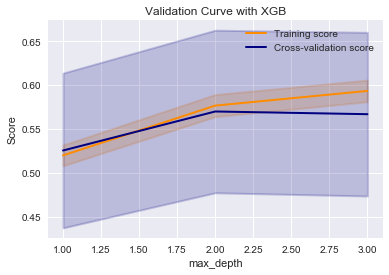

In [18]:
# plot the validation curve
plt.title("Validation Curve with XGB")
plt.xlabel("max_depth")
plt.ylabel("Score")
#plt.ylim(0.0, 1.1)
lw = 2
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, val_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

A max_depth of 2 produced the highest score in the validation sets. Higher complexity of the model produces overfitting. We can see though that the deviation is very high. 

In [20]:
from sklearn.model_selection import validation_curve
t0 = time.time()
print('let us go')
# get validation curve data for selected parameter and range
param_range = range(20,220,40)
train_scores, val_scores = validation_curve(
    model, X_train, y_train, param_name="xgblinear__n_estimators", param_range=param_range,
    cv=10)#, scoring="accuracy", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)
print("Done: {:.1f} s".format(time.time() - t0))

let us go
Done: 276.1 s


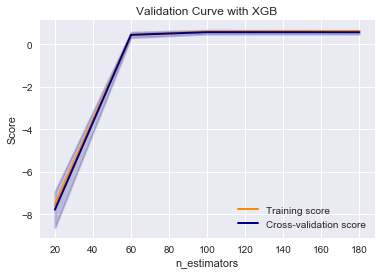

In [21]:
# plot the validation curve
plt.title("Validation Curve with XGB")
plt.xlabel("n_estimators")
plt.ylabel("Score")
#plt.ylim(0.4, 0.8)
lw = 2
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, val_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

The lower the learning_rate the better the model seems to perform. However, a lower_rate might cause the model to run for too long. Therefore, the best candidates could be, for example, 0.5 or 0.1

In [22]:
from sklearn.model_selection import validation_curve
t0 = time.time()
# get validation curve data for selected parameter and range
param_range = [0.01, 0.025, 0.05, 0.75, 1]
train_scores, val_scores = validation_curve(
    model, X_train, y_train, param_name="xgblinear__learning_rate", param_range=param_range,
    cv=10)#, scoring="accuracy", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)
print("Done: {:.1f} s".format(time.time() - t0))

let us go
Done: 499.8 s


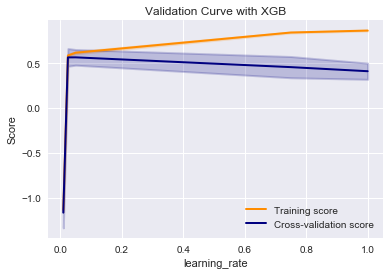

In [25]:
# plot the validation curve
plt.title("Validation Curve with XGB")
plt.xlabel("learning_rate")
plt.ylabel("Score")
#plt.xlim(0, 0.06)
lw = 2
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, val_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

It seems that a learning_rate of 0.025 would be best. 

# Ensemble approach

In [ ]:
# Voting classifier to create ensemble model
from sklearn.ensemble import VotingClassifier
votes = []
votes.append(('xgblinear', xgb.XGBRegressor(**param)))
votes.append(('pipe', model))
ensemble = VotingClassifier(votes, voting='hard')

In [ ]:
# evaluate ensemble
seed = 7
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(ensemble, X_train, y_train, cv=kfold)
print(results.mean())

# Training

In [75]:
# train XGB
print('Training')
t0 = time.time()
num_round = 100
param = {'max_depth':3, 
         'eta':0.05, 'learning_rate':0.05,
         'silent':1, 'objective':'reg:linear', 
         #'subsample':0.5, 'colsample_bytree':0.5, 
         'n_estimators':num_round, 'num_boost_round':num_round}
dtrain = xgb.DMatrix(data=X_train, label=y_train)
#watchlist  = [(dtest,'test'), (dtrain,'train')]
model1 = xgb.train(param, dtrain, num_round)#, early_stopping_rounds=5)
print("Done: {:.1f} s".format(time.time() - t0))

Training


Done: 7.3 s


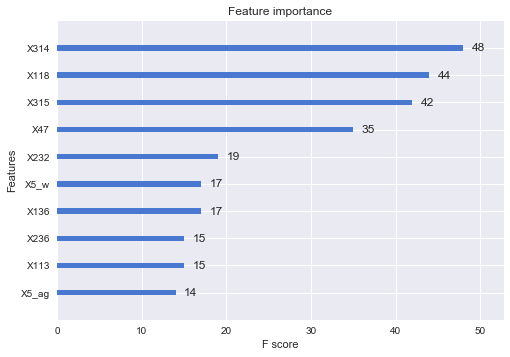

In [12]:
# plot feature importance from xgb model
xgb.plot_importance(model1, max_num_features=10)

# Make test predictions

In [76]:
# get predictions from model
#X_test = test.drop(['ID','y'], axis=1)
dtest = xgb.DMatrix(data=X_test)
y_pred = model1.predict(dtest)

In [77]:
y_pred = y_pred*0.75 + results*0.25

In [78]:
len(os.listdir(os.path.join(os.getcwd(), 'output')))

10

In [79]:
# create submission csv file
dirname = 'output'
count = len(os.listdir(os.path.join(os.getcwd(), dirname))) + 1
filename = 'sub' + str(count) + '_xgb' + '_maxdepth' + str(param['max_depth']) + '_eta' + str(param['eta']) + \
           '_numround' + str(num_round) + '.csv'
pd.concat([test.ID, pd.Series(y_pred)], axis=1).to_csv(dirname + '/' + filename,
                                                       header=['ID', 'y'], index=False)

Score of submission_1 was 0.45031 (1541st place)

Score of submission_2 (num_rounds=2) was 0.55018 (1026th place)

Score of submission_3 (num_rounds=3, depth=4) was 0.54137

Score of submission_3 (xgboost model with additional 10 PCA features (num_rounds = 2, depth=3)) was 0.54010

# Draft for further feature processing

identify categorical and continuous features
for c in train.columns:
    if 0 not in train[c].values:
        print('{0} is categorical'.format(c))
    else:
        print('{0} is binary'.format(c))

cont_feats = [c for c in train.columns if (0 and 1) in train[c].values]
cont_feats
len(cat_feats) + len(cont_feats) == len(train.columns)

cat_feats = [c for c in train.columns if (0 and 1) not in train[c].values]
cat_feats